Feedforward and feedback model

Stimulation: Constant velocity bright bar

With Gain control

Only one contrast

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
%matplotlib inline

In [18]:
#Gain control function
def gain(v,order,B):
    if v <0:
        return 1
    else:
        return 1/(1+(B*v)**order)

In [19]:
def K(x,s):
    return(np.exp(-(x**2/2/s**2)))/s/np.sqrt(2*np.pi)

In [20]:
xlen = 3000#spatial extend of simulation
dxc = 20/xlen
sigma_zu = int(2/dxc)#sigma_zu is horizontal cell receptive field
sigma_v = sigma_zu*0.9#sigma_v is bipolar cell receptive field
sigma_zv = sigma_zu/5#sigma_zv is horizontal to bipolar cell receptive field size
nstep = 2000
##Spatial kernal for horizontal cell
klen = int(sigma_zu*3)
xx = np.arange(0,klen)
khxs = K(xx,sigma_zu)
KH = np.zeros(klen*2-1)
tmp = khxs[::-1]
KH[0:klen]= tmp[0:klen]/dxc
KH[klen:2*klen]=khxs[1:klen]/dxc

##Spatial kernal for horizontal cell to bipolar cell
klen = int(sigma_zv*3)
xx = np.arange(0,klen)
kzvxs = K(xx,sigma_zv)
Kzv = np.zeros(klen*2-1)
tmp = kzvxs[::-1]
Kzv[0:klen]= tmp[0:klen]/dxc
Kzv[klen:2*klen]=kzvxs[1:klen]/dxc

##Spatial kernal for bipolar cell
klen = int(sigma_v*3)
xx = np.arange(0,klen)
kvxs = K(xx,sigma_v)
KV = np.zeros(klen*2-1)
tmp = kvxs[::-1]
KV[0:klen]= tmp[0:klen]/dxc
KV[klen:2*klen]=kvxs[1:klen]/dxc

In [21]:
hw = int(sigma_zu/3)#half of width
dt = 0.001
pos_0 = int(xlen/4)#initial position
pos = pos_0

velocity = 900#speed of bar
tau_u = 40#time constant of cone
tau_z = 2.#time constant of horizontal
tau_v = 100#time constant of bipolar
k = 40#Tune stimulus input and horizontal feedback
g = 2#Tune horizontal cell
psy = 0.5
p = 100
phi = 5
B = 200
order = 4#Order of gain control

In [22]:
xx = np.arange(0,xlen)
u = np.zeros(xlen)#cone
z = np.zeros(xlen)#horizontal cell
v = np.zeros(xlen)#bipolar cell
original_v = np.zeros(xlen)
speak = np.zeros(nstep)
upeak = np.zeros(nstep)
vpeak = np.zeros(nstep)
original_vpeak = np.zeros(nstep)
total_u = np.zeros([int(xlen),nstep])#total cones
total_v = np.zeros([int(xlen),nstep])#total bipolar cells
total_ov = np.zeros([int(xlen),nstep])#total original bipolar cells
total_rzv = np.zeros([int(xlen),nstep])#total horizontal feedforward inhibition to bipolar
total_ruv = np.zeros([int(xlen),nstep])#total horizontal feedback inhibition to cone
zts = np.zeros([int(xlen),nstep])#horizontal
ss = np.zeros([int(xlen),nstep])#bar
gains = np.zeros([int(xlen),nstep])#gain number

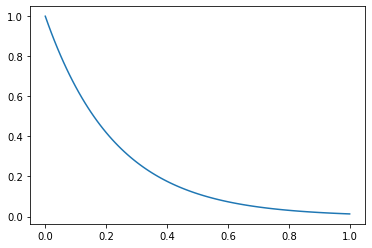

In [23]:
#Feedback filter for u
tau = 0.23#sec
feedback_filter = np.exp(-np.arange(0,1+0.01,0.01)/tau)
plt.plot(np.arange(0,1+0.01,0.01),feedback_filter)

In [24]:
for i in range(nstep):
    #Stimulation (s)
    pos = pos_0 + velocity*dt*i
    speak[i] = pos
    s = np.zeros(xlen)#stimulus
    s[int(pos)-hw:int(pos)+hw] = 1
    
    if i >=len(feedback_filter):#Check the array is longer enough (must longer than feedback filter)
        ru = np.convolve(u,KH,'same')*dxc # feedback from horizontal cell
        ruv = np.convolve(u,KV,'same')*dxc # input from cone
        # rzv = np.convolve(z,Kzv,'same')*dxc # feedforward inhibition from horizontal cell
        for j in range(int(xlen)):
            ####Gain control######
            V = np.convolve(feedback_filter,total_v[j,i-len(feedback_filter)+1:i+1],'valid')*dt#average by expotential filtering
            g = gain(V,order,B)#Gain control
            gains[j,i] = g
            duj =(-tau_u*u[j]+k*(s[j]-phi*z[j]))*dt#Cone
            dzj =(-tau_z*z[j]+g*ru[j])*dt#horizontal
            dvj = (-tau_v*v[j]+p*((1-psy)*ruv[j]-psy*z[j]))*dt#bipolar
            u[j] = u[j]+duj
            z[j] = z[j]+dzj
            v[j] = v[j]+dvj
        v = v*gains[:,i]
        
        
    else:#Doesn't have gain control yet
        ru = np.convolve(u,KH,'same')*dxc # feedback from horizontal cell
        ruv = np.convolve(u,KV,'same')*dxc # input from cone
        duj =(-tau_u*u+k*(s-phi*z))*dt#Cone
        dzj =(-tau_z*z+g*ru)*dt#horizontal
        dvj = (-tau_v*v+p*((1-psy)*ruv-psy*z))*dt#bipolar
        u = u+duj
        z = z+dzj
        v = v+dvj
    total_u[:,i] = u
    total_v[:,i] = v
    u[u<0] = 0
    v[v<0] = 0
    upeak[i]= np.argmax(u)
    vpeak[i]= np.argmax(v)
    total_ov[:,i] = original_v
    ss[:,i] = s
    zts[:,i] = z
    # total_rzv[:,i] = rzv
    total_ruv[:,i] = ruv

50


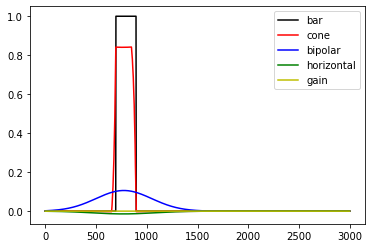

150


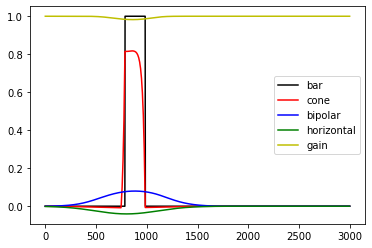

250


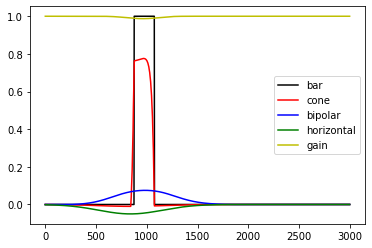

350


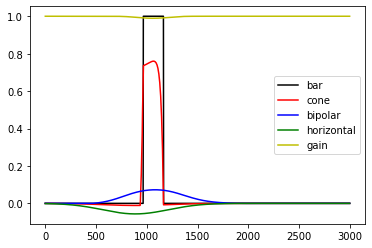

450


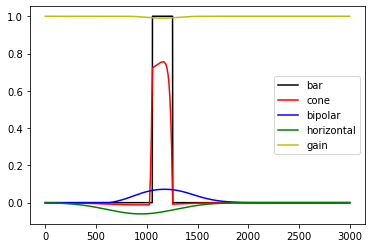

550


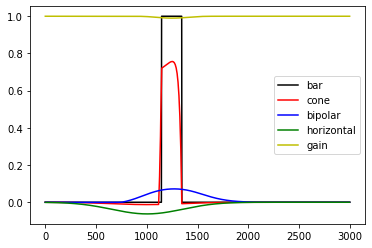

650


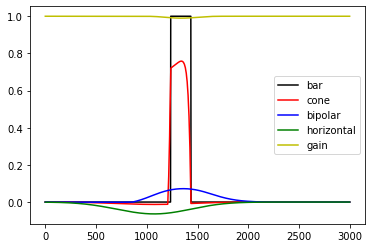

750


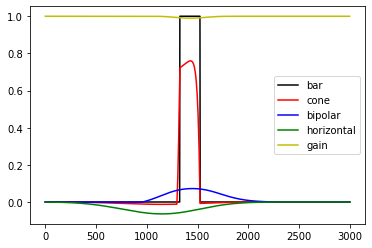

850


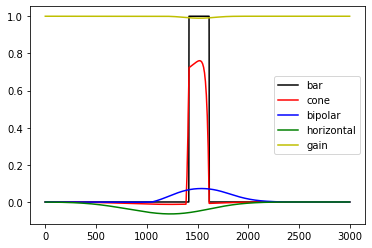

950


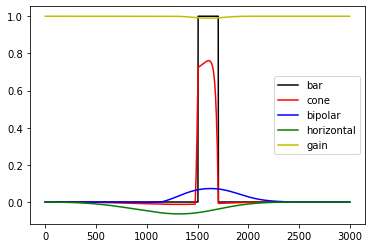

1050


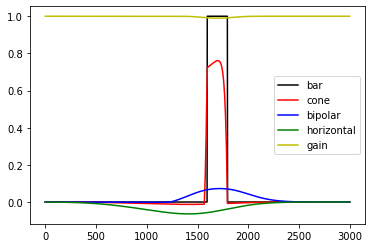

1150


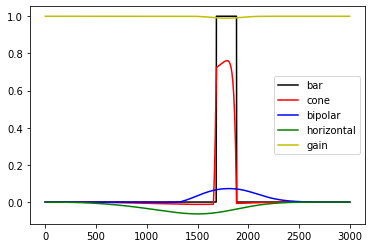

1250


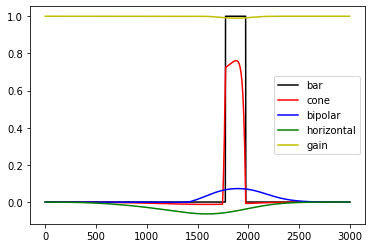

1350


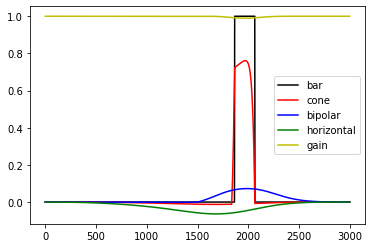

1450


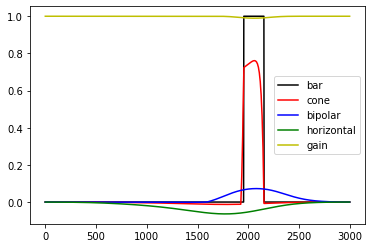

1550


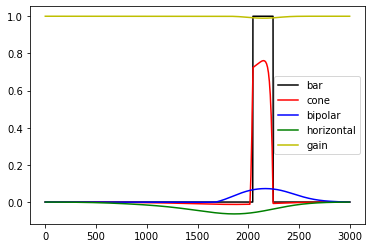

1650


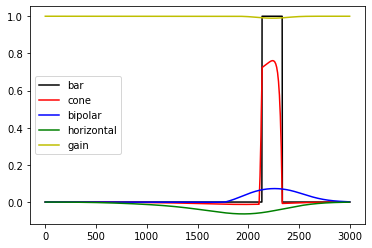

1750


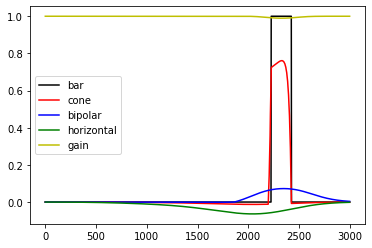

1850


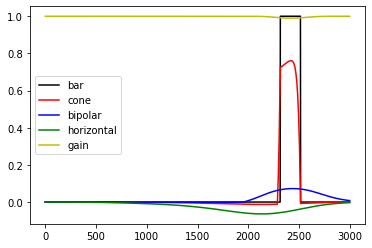

1950


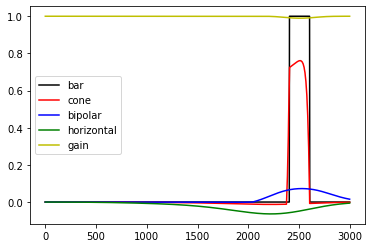

In [25]:
# snapshot at different time
for index in np.arange(50,nstep,100):
    print(index)
    plt.figure()
    plt.plot(xx,ss[:,index],'k',label='bar')#bar
    plt.plot(xx,total_u[:,index],'r',label='cone')#cone
    plt.plot(xx,total_v[:,index],'b',label='bipolar')#bipolar cell
    plt.plot(xx,-zts[:,index],'g',label='horizontal')#horizontal
    plt.plot(xx,gains[:,index],'y',label='gain')#gain value
    plt.legend()
    plt.show()
    

Text(0, 0.5, 'Distance')

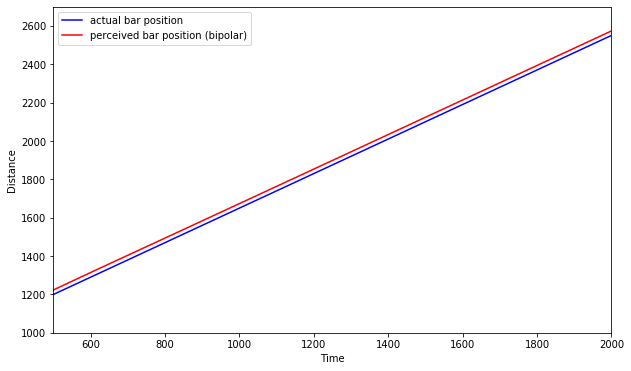

In [26]:
plt.plot(speak,'b',label='actual bar position')
#plt.plot(upeak,'k',label='perceived bar position (cone)')
plt.plot(vpeak,'r',label='perceived bar position (bipolar)')
plt.legend(loc='upper left')
plt.xlim([500,2000])
plt.ylim([1000,2700])
plt.gcf().set_size_inches(5*2,3*2)
#plt.title('Bar position and percieved position')
plt.xlabel('Time')
plt.ylabel('Distance')
#plt.savefig('constant_vnoise_FF_peak_gain_control.jpg')